# SPTAN1

In [1]:
import gpsea
import hpotk
import numpy as np

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using genophenocorr version 0.5.1.dev0


# SPTAN1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SPTAN1.

In [2]:
gene_symbol = 'SPTAN1'
mane_tx_id = 'NM_001130438.3'
mane_protein_id = "NP_001123910.1" # spectrin alpha chain, non-erythrocytic 1 isoform

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.20") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
len(phenopackets)


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed: 100%|██████████| 85/85 [00:04<00:00, 19.08individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewable
cv = CohortViewable(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Intellectual disability,HP:0001249,27
Spastic paraplegia,HP:0001258,21
Ataxia,HP:0001251,20
Distal lower limb muscle weakness,HP:0009053,20
Global developmental delay,HP:0001263,20
Abnormal pyramidal sign,HP:0007256,19
Microcephaly,HP:0000252,19
Hypotonia,HP:0001252,16
Hypsarrhythmia,HP:0002521,16
Cerebellar atrophy,HP:0001272,16


<Axes: title={'center': 'Spectrin alpha chain, non-erythrocytic 1\ntranscript: NM_001130438.3, protein: NP_001123910.1'}>

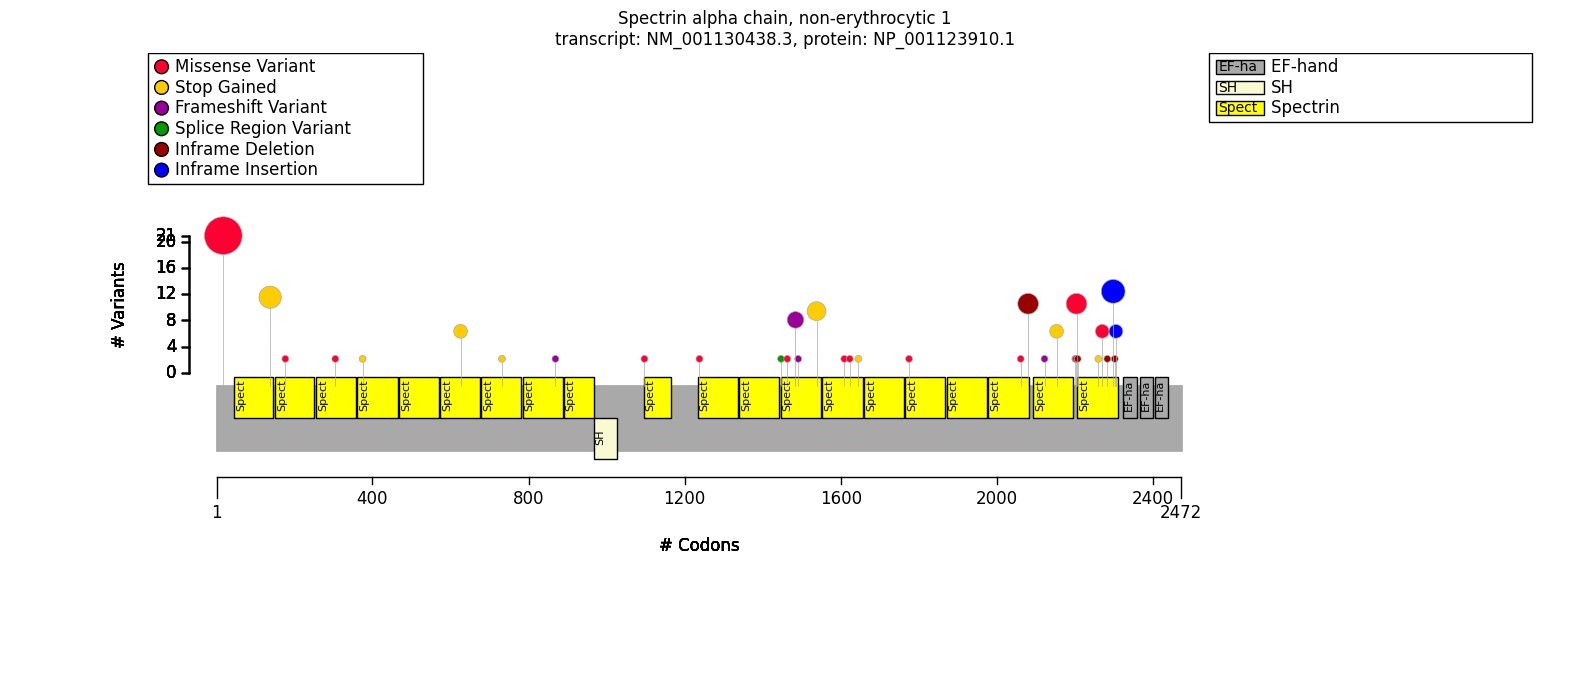

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService, configure_default_protein_metadata_service
from gpsea.model import ProteinMetadata

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id) 
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)
#protein_meta = ProteinMetadata.from_uniprot_json(uniprot_json="P02461.json", label="Collagen alpha-1(III) chain", protein_length=1466, protein_id=mane_protein_id)


from gpsea.view import ProteinVisualizable, ProteinVisualizer

pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis)

In [6]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort)

Name,Type,Coordinates,Count,Variants
Spectrin 1,REPEAT,45 - 146,6,p.Arg139Ter
Spectrin 2,REPEAT,150 - 251,1,p.Gly178Asp
Spectrin 3,REPEAT,256 - 358,1,p.Ala306Val
Spectrin 4,REPEAT,361 - 465,1,p.Trp376Ter
Spectrin 5,REPEAT,468 - 570,0,
Spectrin 6,REPEAT,574 - 676,2,p.Arg627Ter
Spectrin 7,REPEAT,679 - 781,1,p.Arg733Ter
Spectrin 8,REPEAT,785 - 888,1,p.Lys871SerfsTer5
Spectrin 9,REPEAT,891 - 969,0,
SH3,DOMAIN,967 - 1026,0,


In [7]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
9_128566795_128566795_C_T,c.55C>T,p.Arg19Trp,2,missense,21
9_128632260_128632260_G_GGGACCAGCT,c.6908_6916dup,p.Asp2303_Leu2305dup,53,inframe insertion,6
9_128574726_128574726_C_T,c.415C>T,p.Arg139Ter,4,stop gained,6
9_128625939_128625942_CAAG_C,c.6247_6249del,p.Lys2083del,48,inframe deletion,5
SO:1000029_HGNC:11273_SPTAN1,SV involving SPTAN1,p.?,,chromosomal deletion,4
9_128609141_128609141_C_T,c.4615C>T,p.Gln1539Ter,36,stop gained,4
9_128627422_128627425_CAGG_C,c.6619_6621del,p.Glu2207del,50,inframe deletion,4
9_128608237_128608238_CA_C,c.4458del,p.Lys1486AsnfsTer51,34,frameshift,3
9_128583149_128583149_C_T,c.1879C>T,p.Arg627Ter,15,stop gained,2
9_128632280_128632280_G_GGCATGC,c.6923_6928dup,p.Arg2308_Met2309dup,53,inframe insertion,2


In [8]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    missing_implies_excluded=False,
    min_n_of_patients_with_term=2,
)
len(pheno_predicates)
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(
    hpo=hpo,
    term_frequency_threshold=0.4,
)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
     mtc_alpha=mtc_alpha,
)

In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)


gt_predicate = monoallelic_predicate(a_predicate=missense, b_predicate=~missense, 
                                   names=("missense", "other"),
                                   )
print(gt_predicate.display_question())
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Allele group: missense, other


Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,23
HMF03,Skipping term because of a child term with the same individual counts,2
HMF08,Skipping general term,37
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.25,114


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                       missense          other  \
                                                      Count Percent  Count   
Lower limb spasticity [HP:0002061]                    21/22     95%   0/12   
Spastic paraplegia [HP:0001258]                       21/25     84%   0/16   
Appendicular spasticity [HP:0034353]                  21/22     95%   2/14   
Spasticity [HP:0001257]                               22/23     96%   4/16   
Motor axonal neuropathy [HP:0007002]                   0/19      0%   9/13   
Epileptic spasm [HP:0011097]                           2/22      9%  13/17   
Seizure [HP:0001250]                                  13/33     39%  24/28   
Intellectual disability [HP:0001249]                   9/32     28%  18/23   
Peripheral axonal neuropathy [HP:0003477]              4/23     17%  12/16   
Cerebellar atrophy [HP:0001272]                         1/9     11%  15/19   
Motor seizure [HP:0020219]                             7/27     26%  13/17   
Spastic gait [HP:0002064]                              6/10     60%   0/13   
Infantile spasms [HP:0012469]                          2/29      7%  13/31   
Microcephaly [HP:0000252]                              4/34     12%  15/32   
Dialeptic seizure [HP:0011146]                         2/22      9%    5/9   
Lower limb muscle weakness [HP:0007340]               15/16     94%  15/27   
Non-motor seizure [HP:0033259]                         1/21      5%    3/7   
Generalized-onset seizure [HP:0002197]                 1/21      5%    3/7   
Seizure precipitated by febrile infection [HP:0...     1/21      5%    3/7   
Focal-onset seizure [HP:0007359]                       3/23     13%    3/7   
Abnormal pyramidal sign [HP:0007256]                  19/20     95%    4/6   
Pes cavus [HP:0001761]                                 6/24     25%    3/7   
Hypotonia [HP:0001252]                                  3/9     33%  13/26   
Ataxia [HP:0001251]                                   11/30     37%   9/20   
Distal lower limb muscle weakness [HP:0009053]         9/19     47%  11/27   
Upper motor neuron dysfunction [HP:0002493]           24/24    100%    7/7   
Hypertonia [HP:0001276]                               22/22    100%    4/4   
Abnormal muscle tone [HP:0003808]                     24/24    100%  16/16   
Neurodevelopmental delay [HP:0012758]                   5/5    100%  30/30   
Neurodevelopmental abnormality [HP:0012759]           11/11    100%  35/35   
Abnormal axial skeleton morphology [HP:0009121]         5/5    100%  17/17   
Abnormality of coordination [HP:0011443]              11/11    100%  11/11   
Limb muscle weakness [HP:0003690]                     17/17    100%  16/16   
Muscle weakness [HP:0001324]                          17/17    100%  19/19   
Morphological central nervous system abnormalit...      5/5    100%  24/24   
Abnormal cerebral morphology [HP:0002060]               4/4    100%  19/19   
Abnormal brain morphology [HP:0012443]                  5/5    100%  24/24   

Allele group                                                                   \
                                                   Percent Corrected p values   
Lower limb spasticity [HP:0002061]                      0%       8.695646e-07   
Spastic paraplegia [HP:0001258]                         0%       8.695646e-07   
Appendicular spasticity [HP:0034353]                   14%       1.075996e-05   
Spasticity [HP:0001257]                                25%       4.830885e-05   
Motor axonal neuropathy [HP:0007002]                   69%       1.803874e-04   
Epileptic spasm [HP:0011097]                           76%       1.803874e-04   
Seizure [HP:0001250]                                   86%       1.311417e-03   
Intellectual disability [HP:0001249]                   78%       1.585493e-03   
Peripheral axonal neuropathy [HP:0003477]              75%       2.750326e-03   
Cerebellar atrophy [HP:0001272]                        79%       4

In [11]:
is_r19w = VariantPredicates.variant_key(key="9_128566795_128566795_C_T") # c.55C>T	p.Arg19Trp
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                       missense          other  \
                                                      Count Percent  Count   
Lower limb spasticity [HP:0002061]                    21/22     95%   0/12   
Spastic paraplegia [HP:0001258]                       21/25     84%   0/16   
Appendicular spasticity [HP:0034353]                  21/22     95%   2/14   
Spasticity [HP:0001257]                               22/23     96%   4/16   
Motor axonal neuropathy [HP:0007002]                   0/19      0%   9/13   
Epileptic spasm [HP:0011097]                           2/22      9%  13/17   
Seizure [HP:0001250]                                  13/33     39%  24/28   
Intellectual disability [HP:0001249]                   9/32     28%  18/23   
Peripheral axonal neuropathy [HP:0003477]              4/23     17%  12/16   
Cerebellar atrophy [HP:0001272]                         1/9     11%  15/19   
Motor seizure [HP:0020219]                             7/27     26%  13/17   
Spastic gait [HP:0002064]                              6/10     60%   0/13   
Infantile spasms [HP:0012469]                          2/29      7%  13/31   
Microcephaly [HP:0000252]                              4/34     12%  15/32   
Dialeptic seizure [HP:0011146]                         2/22      9%    5/9   
Lower limb muscle weakness [HP:0007340]               15/16     94%  15/27   
Non-motor seizure [HP:0033259]                         1/21      5%    3/7   
Generalized-onset seizure [HP:0002197]                 1/21      5%    3/7   
Seizure precipitated by febrile infection [HP:0...     1/21      5%    3/7   
Focal-onset seizure [HP:0007359]                       3/23     13%    3/7   
Abnormal pyramidal sign [HP:0007256]                  19/20     95%    4/6   
Pes cavus [HP:0001761]                                 6/24     25%    3/7   
Hypotonia [HP:0001252]                                  3/9     33%  13/26   
Ataxia [HP:0001251]                                   11/30     37%   9/20   
Distal lower limb muscle weakness [HP:0009053]         9/19     47%  11/27   
Upper motor neuron dysfunction [HP:0002493]           24/24    100%    7/7   
Hypertonia [HP:0001276]                               22/22    100%    4/4   
Abnormal muscle tone [HP:0003808]                     24/24    100%  16/16   
Neurodevelopmental delay [HP:0012758]                   5/5    100%  30/30   
Neurodevelopmental abnormality [HP:0012759]           11/11    100%  35/35   
Abnormal axial skeleton morphology [HP:0009121]         5/5    100%  17/17   
Abnormality of coordination [HP:0011443]              11/11    100%  11/11   
Limb muscle weakness [HP:0003690]                     17/17    100%  16/16   
Muscle weakness [HP:0001324]                          17/17    100%  19/19   
Morphological central nervous system abnormalit...      5/5    100%  24/24   
Abnormal cerebral morphology [HP:0002060]               4/4    100%  19/19   
Abnormal brain morphology [HP:0012443]                  5/5    100%  24/24   

Allele group                                                                   \
                                                   Percent Corrected p values   
Lower limb spasticity [HP:0002061]                      0%       8.695646e-07   
Spastic paraplegia [HP:0001258]                         0%       8.695646e-07   
Appendicular spasticity [HP:0034353]                   14%       1.075996e-05   
Spasticity [HP:0001257]                                25%       4.830885e-05   
Motor axonal neuropathy [HP:0007002]                   69%       1.803874e-04   
Epileptic spasm [HP:0011097]                           76%       1.803874e-04   
Seizure [HP:0001250]                                   86%       1.311417e-03   
Intellectual disability [HP:0001249]                   78%       1.585493e-03   
Peripheral axonal neuropathy [HP:0003477]              75%       2.750326e-03   
Cerebellar atrophy [HP:0001272]                        79%       4

In [12]:
from gpseacs import GpseaSummarizer, SignificantResults

In [13]:
sig_results = SignificantResults(hpo=hpo)

In [14]:
sig_results.fisher_exact_test(result=result)

extracted 16 FET significant results


In [15]:
summarizer = GpseaSummarizer(version = gpsea.__version__,
                caption = "todo",
                cohort = cohort, 
                tx_id=mane_tx_id,
                hpo=hpo,
                sig_results=sig_results)



In [16]:
print(summarizer.gpsea_version)
print(summarizer.hpo_version)

0.5.1.dev0
2023-10-09


In [17]:
from gpseacs import HtmlVisualizer
vizualizer = HtmlVisualizer()
vizualizer.process(summarizer=summarizer)

HPO Term,genotype (A),individuals (A),genotype (B),individuals (B),p-val,adj. p-val,test
,21/25,,0%,,,,
,21/22,,0%,,,,
,21/22,,14%,,,,
,22/23,,25%,,,,
,0/19,,69%,,,,
,4/23,,75%,,,,
,7/27,,76%,,,,
,13/33,,86%,,,,
,2/22,,56%,,,,
,9/32,,78%,,,,
